In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def map_image(image, label):
    noise_factor = 0.5
    image = tf.cast(image, dtype=tf.float32)
    image = image / 255.0
    
    factor = noise_factor * tf.random.normal(shape=image.shape)
    image_noisy = image + factor
    image_noisy = tf.clip_by_value(image_noisy, clip_value_min=0.0, clip_value_max=1.0)
    image_noisy = tf.reshape(image_noisy, shape=(28, 28, 1))
    
    return image_noisy, image

In [3]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [4]:
def cnn_encoder(inputs):
    conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(maxpool1)
    maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    return maxpool2

def cnn_decoder(encoded):
    upsample1 = tf.keras.layers.UpSampling2D(size=(2, 2))(encoded)
    conv3 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(upsample1)
    upsample2 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv3)
    decoded = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same')(upsample2)
    return decoded

def bottle_neck(inputs):
    bottle_neck = tf.keras.layers.Dense(256, activation='relu')(inputs)
    encoder_visualization = tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same')(bottle_neck)
    return bottle_neck, encoder_visualization

def cnn_autoencoder():
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    encoder_output = cnn_encoder(inputs)
    bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
    decoder_output = cnn_decoder(bottleneck_output)
    
    model = tf.keras.Model(inputs=inputs, outputs=decoder_output)
    encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
    return model, encoder_model

autoencoder, encoder = cnn_autoencoder()


In [5]:
encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7, 7, 256)      │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 1)        │         2,305 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,825 (429.00 KB)

 Trainable params: 109,825 (429.00 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7, 7, 256)      │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │       147,520 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 1)      │           577 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 255,617 (998.50 KB)

 Trainable params: 255,617 (998.50 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy')

In [8]:
step=60000//BATCH_SIZE
his = autoencoder.fit(train_dataset,steps_per_epoch=step,epochs=4)

Epoch 1/4
468/468 ━━━━━━━━━━━━━━━━━━━━ 205s 435ms/step - loss: 0.3564
Epoch 2/4
468/468 ━━━━━━━━━━━━━━━━━━━━ 213s 455ms/step - loss: 0.3031
Epoch 3/4
468/468 ━━━━━━━━━━━━━━━━━━━━ 207s 442ms/step - loss: 0.2984
Epoch 4/4
468/468 ━━━━━━━━━━━━━━━━━━━━ 172s 367ms/step - loss: 0.2957


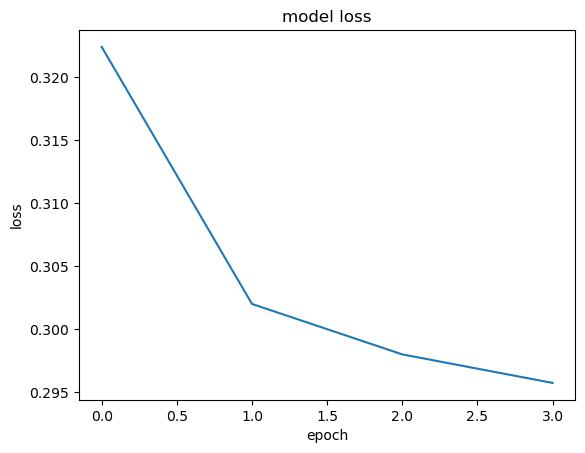

In [9]:
plt.plot(his.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [10]:
def display_one_row(disp_images, offset, shape=(28, 28)):
    '''Display sample outputs in one row.'''
    for idx, test_image in enumerate(disp_images):
        plt.subplot(3, 10, offset + idx + 1)
        plt.xticks([])
        plt.yticks([])
        test_image = np.reshape(test_image, shape)
        plt.imshow(test_image, cmap='gray')

def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape):
    '''Displays the input, encoded, and decoded output values.'''
    plt.figure(figsize=(15, 5))
    display_one_row(disp_input_images, 0, shape=(28, 28))
    display_one_row(disp_encoded, 10, shape=enc_shape)
    display_one_row(disp_predicted, 20, shape=(28, 28))

 1/79 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step

2024-10-21 22:57:34.978664: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step
Encoded shape: (10000, 7, 7, 1)


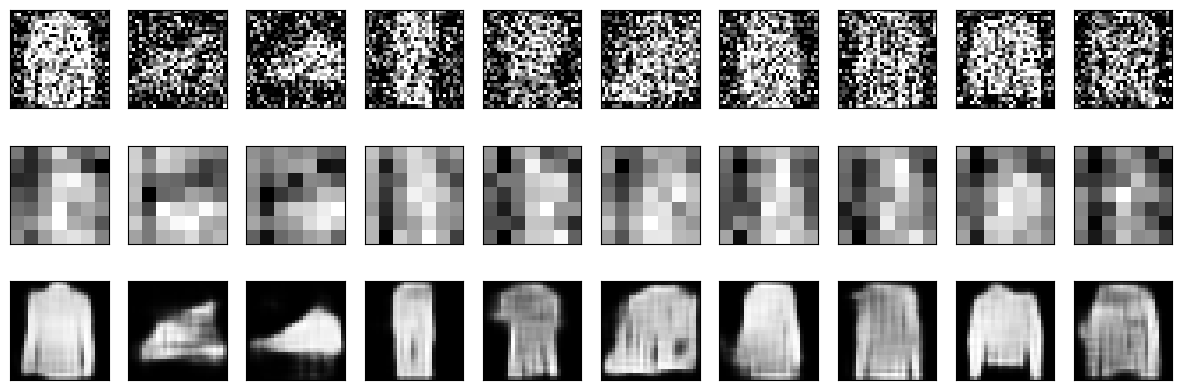

In [11]:
# Extract input images from the dataset
output_samples = []
for input_image, _ in tfds.as_numpy(test_dataset):
    output_samples.extend(input_image)

# Choose 10 random indices to visualize
idxs = np.random.choice(len(output_samples), size=10)

# Get encoder and autoencoder predictions
encoded_predicted = encoder.predict(test_dataset)
simple_predicted = autoencoder.predict(test_dataset)

# Check the shape of the encoded output
print(f"Encoded shape: {encoded_predicted.shape}")

# Determine the correct shape of the encoded images
# Assume the encoded output is in the shape (batch_size, h, w, channels)
# Flatten each encoded image to visualize properly
encoded_flat_shape = (encoded_predicted.shape[1], encoded_predicted.shape[2] * encoded_predicted.shape[3])

# Display the results
display_results(
    [output_samples[i] for i in idxs], 
    [encoded_predicted[i].reshape(encoded_flat_shape) for i in idxs], 
    [simple_predicted[i] for i in idxs],
    enc_shape=encoded_flat_shape
)
plt.show()
